In [1]:
from collections import Counter, defaultdict
import os
import time


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=40,40
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

2022-07-20 20:06:23.619879: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
ds, ds_info = tfds.load(
    "lfw",
    split="train",
    as_supervised=True,
    with_info=True,
)

2022-07-20 20:06:24.906654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 20:06:25.326825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

2022-07-20 20:06:25.676557: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


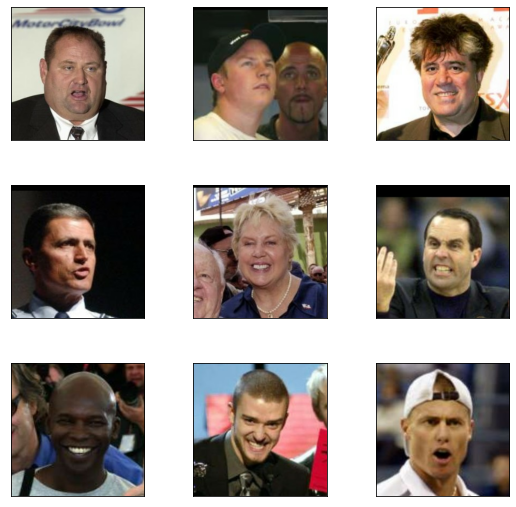

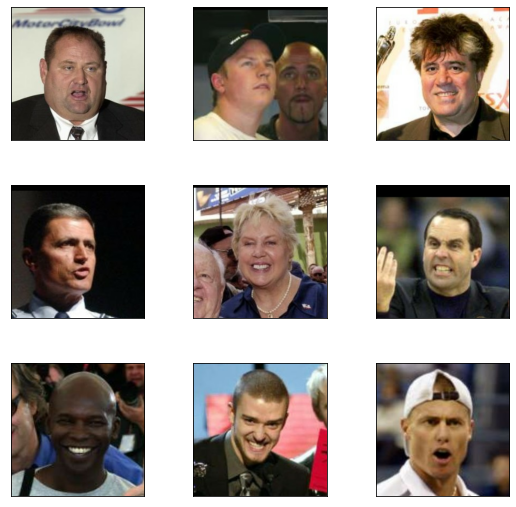

In [4]:
tfds.show_examples(ds, ds_info)

In [5]:
counts = Counter(ds.map(lambda l, i: l).as_numpy_iterator())

In [6]:
counts.most_common(50)

[(b'George_W_Bush', 530),
 (b'Colin_Powell', 236),
 (b'Tony_Blair', 144),
 (b'Donald_Rumsfeld', 121),
 (b'Gerhard_Schroeder', 109),
 (b'Ariel_Sharon', 77),
 (b'Hugo_Chavez', 71),
 (b'Junichiro_Koizumi', 60),
 (b'Jean_Chretien', 55),
 (b'John_Ashcroft', 53),
 (b'Serena_Williams', 52),
 (b'Jacques_Chirac', 52),
 (b'Vladimir_Putin', 49),
 (b'Luiz_Inacio_Lula_da_Silva', 48),
 (b'Gloria_Macapagal_Arroyo', 44),
 (b'Jennifer_Capriati', 42),
 (b'Arnold_Schwarzenegger', 42),
 (b'Lleyton_Hewitt', 41),
 (b'Laura_Bush', 41),
 (b'Hans_Blix', 39),
 (b'Alejandro_Toledo', 39),
 (b'Nestor_Kirchner', 37),
 (b'Andre_Agassi', 36),
 (b'Alvaro_Uribe', 35),
 (b'Megawati_Sukarnoputri', 33),
 (b'Silvio_Berlusconi', 33),
 (b'Tom_Ridge', 33),
 (b'Kofi_Annan', 32),
 (b'Roh_Moo-hyun', 32),
 (b'Vicente_Fox', 32),
 (b'David_Beckham', 31),
 (b'John_Negroponte', 31),
 (b'Guillermo_Coria', 30),
 (b'Recep_Tayyip_Erdogan', 30),
 (b'Bill_Clinton', 29),
 (b'Mahmoud_Abbas', 29),
 (b'Juan_Carlos_Ferrero', 28),
 (b'Jack_Straw

In [7]:
def train_val_test_split(dataset, count_threshold=100):
    # filter any label with < count_threshold occurences
    # and truncate number of examples to count_threshold
    counts = Counter(l for l in list(ds.map(lambda label, image: label).as_numpy_iterator()))
    added = defaultdict(int)
    byte_labels = []
    images = []
    for label, image in ds.as_numpy_iterator():
        if counts[label] >= count_threshold and added[label] < count_threshold:
            added[label] += 1
            byte_labels.append(label)
            images.append(image)
    
    image_array = np.stack(images)
    
    label_encoder = LabelEncoder()
    label_array = label_encoder.fit_transform(byte_labels)
    
    # split into train, validation, test in a stratified manner
    X_train, X_test, y_train, y_test = train_test_split(
        image_array,
        label_array,
        test_size=0.15,
        random_state=42,
        shuffle=True,
        stratify=label_array,
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.15,
        random_state=42,
        shuffle=True,
        stratify=y_train,
    )
    
    return (
        tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train))),
        tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_val), tf.convert_to_tensor(y_val))),
        tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test))),
        label_encoder,
    )


In [8]:
raw_train_ds, raw_val_ds, raw_test_ds, label_encoder = train_val_test_split(ds, count_threshold=40)
n_classes = len(label_encoder.classes_)

In [9]:
train_labels_np = np.stack(list(raw_train_ds.map(lambda X, y: y).as_numpy_iterator()))
val_labels_np = np.stack(list(raw_val_ds.map(lambda X, y: y).as_numpy_iterator()))
test_labels_np = np.stack(list(raw_test_ds.map(lambda X, y: y).as_numpy_iterator()))

train_labels_bincount = np.bincount(train_labels_np)
val_labels_bincount = np.bincount(val_labels_np)
test_labels_bincount = np.bincount(test_labels_np)

diff = train_labels_bincount - (val_labels_bincount * (train_labels_bincount.sum() / val_labels_bincount.sum()))

print(np.min(diff), np.mean(diff), np.median(diff), np.max(diff), np.std(diff))


-5.958762886597938 -2.243819165558211e-15 0.7010309278350491 0.7010309278350491 2.0438388085024757


In [10]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    return keras.applications.resnet50.preprocess_input(image), label

def lazy_preprocess_dataset(train, val, test, batch_size=32):
    train = train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val = val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train, val, test



In [11]:
train_ds, val_ds, test_ds = lazy_preprocess_dataset(raw_train_ds, raw_val_ds, raw_test_ds)

In [12]:
def build_model(n_classes):
    base_model = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
    )
    base_model.trainable=False

    model = keras.models.Sequential()
    model.add(keras.layers.Resizing(224, 224))
    model.add(base_model)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(n_classes, activation="softmax"))
        
    optimizer = keras.optimizers.Nadam(learning_rate=1e-3, decay=0.01)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    
    return model, base_model

In [13]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs")

def get_tensorboard_cb(profile_batch=0):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    file_writer = tf.summary.create_file_writer(run_dir)
    file_writer.set_as_default()
    return keras.callbacks.TensorBoard(run_dir, profile_batch=profile_batch) 

def train_model(name, model, train_ds, val_ds, n_epochs=50):
    checkpoint_cb = keras.callbacks.ModelCheckpoint(f"{name}_model.h5", save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    tensorboard_cb = get_tensorboard_cb()
    
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    history = model.fit(train_ds, epochs=n_epochs, validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [14]:
model, base_model = build_model(n_classes)

94765736/94765736 [==============================] - 3s 0us/step


In [15]:
train_model("xception_dense_top_layer", model, train_ds, val_ds, n_epochs=100)

Epoch 1/100


2022-07-20 20:06:37.459022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-20 20:06:38.054237: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-20 20:06:38.055292: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-20 20:06:38.055316: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-20 20:06:38.056480: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-20 20:06:38.056637: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 2/18 [==>...........................] - ETA: 1s - loss: 3.5233 - accuracy: 0.0312  

2022-07-20 20:06:38.800907: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


18/18 [==============================] - 6s 119ms/step - loss: 2.9262 - accuracy: 0.1111 - val_loss: 2.4025 - val_accuracy: 0.2268
Epoch 2/100
18/18 [==============================] - 1s 61ms/step - loss: 2.0663 - accuracy: 0.3716 - val_loss: 1.9606 - val_accuracy: 0.3402
Epoch 3/100
18/18 [==============================] - 1s 62ms/step - loss: 1.5895 - accuracy: 0.5738 - val_loss: 1.7236 - val_accuracy: 0.4948
Epoch 4/100
18/18 [==============================] - 1s 61ms/step - loss: 1.2704 - accuracy: 0.7140 - val_loss: 1.5791 - val_accuracy: 0.5567
Epoch 5/100
18/18 [==============================] - 1s 60ms/step - loss: 1.0426 - accuracy: 0.7978 - val_loss: 1.4826 - val_accuracy: 0.5670
Epoch 6/100
18/18 [==============================] - 1s 60ms/step - loss: 0.8720 - accuracy: 0.8543 - val_loss: 1.4120 - val_accuracy: 0.6082
Epoch 7/100
18/18 [==============================] - 1s 61ms/step - loss: 0.7397 - accuracy: 0.8925 - val_loss: 1.3572 - val_accuracy: 0.6289
Epoch 8/100
18/18

4/4 [==============================] - 1s 25ms/step


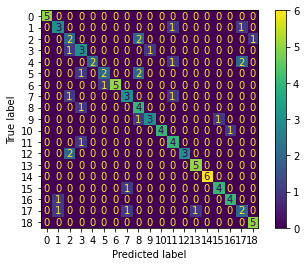

In [16]:
def compute_confusion_matrix(model, ds):
    y_val_pred = model.predict(ds).argmax(axis=-1)
    y_val_true = list(ds.map(lambda X, y: y).unbatch().as_numpy_iterator())
    return confusion_matrix(y_val_true, y_val_pred)

def plot_confusion_matrix(model, ds):
    cm = compute_confusion_matrix(model, ds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
def plot_false_positives_by_class(model, ds):
    cm = compute_confusion_matrix(model, ds)
    for i in range(len(cm)):
        cm[i][i] = 0
    fp_by_class = cm.sum(axis=0)
    plt.plot(fp_by_class)

plot_confusion_matrix(model, val_ds)

4/4 [==============================] - 0s 24ms/step


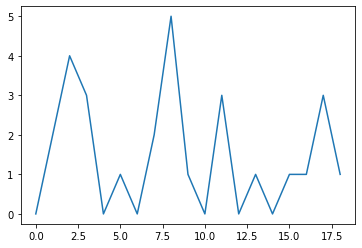

In [17]:
plot_false_positives_by_class(model, val_ds)

In [18]:
base_model.trainable = True

optimizer = keras.optimizers.Nadam(learning_rate=5e-4, decay=0.001)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"],
)

train_model("xception_fully_trainable_pretrained_top_layer", model, train_ds, val_ds, n_epochs=25)

Epoch 1/25
18/18 [==============================] - 15s 213ms/step - loss: 0.3729 - accuracy: 0.8852 - val_loss: 23.2143 - val_accuracy: 0.1340
Epoch 2/25
18/18 [==============================] - 3s 154ms/step - loss: 0.2693 - accuracy: 0.9271 - val_loss: 12.7060 - val_accuracy: 0.2577
Epoch 3/25
18/18 [==============================] - 3s 159ms/step - loss: 0.1011 - accuracy: 0.9690 - val_loss: 6.4410 - val_accuracy: 0.4742
Epoch 4/25
18/18 [==============================] - 2s 107ms/step - loss: 0.0701 - accuracy: 0.9836 - val_loss: 13.1415 - val_accuracy: 0.2784
Epoch 5/25
18/18 [==============================] - 3s 155ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 4.5435 - val_accuracy: 0.5670
Epoch 6/25
18/18 [==============================] - 3s 153ms/step - loss: 7.7711e-04 - accuracy: 1.0000 - val_loss: 2.1644 - val_accuracy: 0.7216
Epoch 7/25
18/18 [==============================] - 3s 151ms/step - loss: 4.0257e-04 - accuracy: 1.0000 - val_loss: 1.3054 - val_accuracy: 0

4/4 [==============================] - 1s 25ms/step


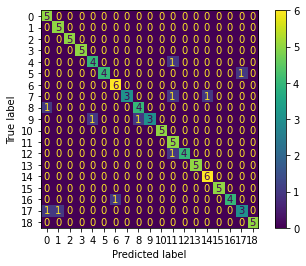

In [19]:
plot_confusion_matrix(model, val_ds)

4/4 [==============================] - 0s 26ms/step


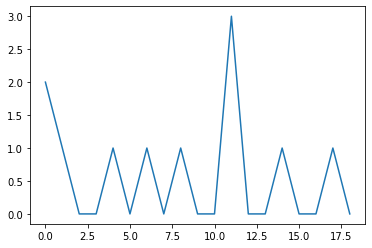

In [20]:
plot_false_positives_by_class(model, val_ds)

4/4 [==============================] - 0s 82ms/step


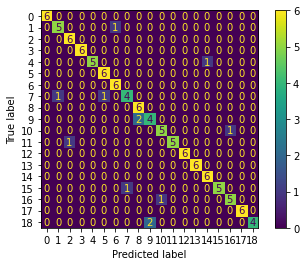

In [21]:
plot_confusion_matrix(model, test_ds)

In [22]:
model.evaluate(test_ds)

4/4 [==============================] - 0s 26ms/step - loss: 0.4320 - accuracy: 0.8947


[0.43201932311058044, 0.8947368264198303]

4/4 [==============================] - 0s 24ms/step


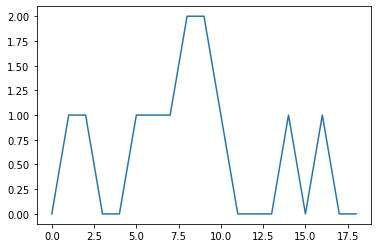

In [23]:
plot_false_positives_by_class(model, test_ds)